# Introduction
This notebook covers part 1 of the data analysis for the paper: "3D-printed registration phantom for multiscale ultrasound and optical microscopy of small tissue samples."


1.) Rotation: Calculating coordinate system transforms and standard deviations for the fiducial phantom over 5 rotations.

2.) Height: Calculating the coordinate system transforms and standard deviations for the fiducial phantom over 7 heights.

3.) Tendon: Apply the transform onto an image of a tendon.


In [1]:
# Import basic modules
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [2]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.ultrasound.reconstruction as recon
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.itk.process as proc
import multiscale.utility_functions as util

The function definitions below are provided to show the operations applied to acquire the results.  These functions have also been adapted into the multiscale imaging package.  The modified versions are used in the single registration example notebook and the apply registration example notebook.

In [3]:
# These function definitions are used for the analysis.

def open_us(us_path, dynamic_range, spacing, origin):
    """Open the US image, window it to a dynamic range, and rotate it to microscope coordinate axes"""
    raw_image = sitk.ReadImage(str(us_path))
    windowed_image = proc.window_image(raw_image, dynamic_range)
    us_image = rotate_axes_to_microscope(windowed_image)
    us_image.SetSpacing(spacing)
    us_image.SetOrigin(origin)
    us_image.SetDirection([1, 0, 0, 0, 1, 0, 0, 0, -1])
    return us_image

def open_mpm(mpm_path, mpm_origin_path, mpm_spacing):
    """Open the MPM image and set the direction to -1 in Z to mirror microscope convention"""
    positions = positions_from_ometif(mpm_origin_path)
    origin = np.min(positions, 0)
    mpm_image = sitk.ReadImage(str(mpm_path))
    mpm_image.SetSpacing(mpm_spacing)
    mpm_image.SetOrigin(origin)
    mpm_image.SetDirection([1, 0, 0, 0, 1, 0, 0, 0, -1])
    return mpm_image

def rotate_axes_to_microscope(image):
    """Rotate the US axes to be along the microscope axes"""
    arr = sitk.GetArrayFromImage(image)
    arr_rot = np.swapaxes(arr, 0, 1)
    arr_rot = np.flip(arr_rot, 0).astype(np.uint8)
    return sitk.GetImageFromArray(arr_rot)

def positions_from_ometif(file_path):
    """Read a .ome.tif file and grab the image positions as a numpy array"""
    reader = sitk.ImageFileReader()
    reader.SetFileName(str(file_path))
    reader.ReadImageInformation()
    raw_info = reader.GetMetaData('ImageDescription')
    info = tif.xml2dict(raw_info)
    mpm_list = []
    for position in info['OME']['Image']:
        x = position['StageLabel']['X']
        y = position['StageLabel']['Y']
        z = position['Pixels']['Plane'][0]['PositionZ']
        mpm_list.append(np.array([x, y, z]))
    return np.array(mpm_list)

def get_xy_origin(pl_path):
    """Read an ultrasound position list and get the XY origin"""
    raw_pos_list = util.read_json(pl_path)
    pos_list = recon.clean_position_text(raw_pos_list)[0]
    xy_origin = np.min(pos_list, 0)
    return xy_origin

def connected_components(us_image):
    """Process the US image using Otsu thresholding and binary opening/closing to get the connected components"""
    thresh_filter = sitk.OtsuThresholdImageFilter()
    thresh_filter.SetInsideValue(0)
    thresh_filter.SetOutsideValue(1)
    thresh_img = thresh_filter.Execute(us_image)
    thresh_value = thresh_filter.GetThreshold()

    print("Threshold used: {}".format(thresh_value))

    cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [4, 4, 2])
    cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [4, 4, 2])

    connected_img = sitk.ConnectedComponent(cleaned_thresh_img)
    return connected_img

def get_fiducial_stats(connected_img):
    """Get statistics for each object in a label image"""
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.ComputeOrientedBoundingBoxOn()
    stats.ComputePerimeterOn()
    stats.Execute(connected_img)    
    return stats

def filter_labels(stats):
    """Filter labels by property so you only get the fiducial circles"""
    return [l for l in stats.GetLabels() if (stats.GetNumberOfPixels(l) < 300000 
                                             and stats.GetEquivalentEllipsoidDiameter(l)[1] > 2000)]

def get_leveled_centroid(stats, true_labels):
    """Get the leveled Z height, equivalent to the bottom of fiducial, for each label"""
    centroid = [stats.GetCentroid(l) for l in true_labels]
    level_center = []
    idx = 0
    for center in centroid:
        level_center.append(center[2] + np.floor((idx+3)/3)*1000)
        idx = idx+1
    return np.array(level_center)

def apply_transform(moving_image, fixed_image, transform_params):
    """Apply a rigid transform based on input parameters"""
    transform = sitk.VersorRigid3DTransform()
    transform.SetParameters(transform_params)
    reg = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, 0.0, fixed_image.GetPixelID())
    return reg

def calculate_centroid(image):
    """Take a connected component image and calculate Z height of fiducials"""
    stats = get_fiducial_stats(image)
    labels = filter_labels(stats)
    centroids = get_leveled_centroid(stats, labels)
    return centroids

In [4]:
# The input files are available at https://uwmadison.box.com/s/05ou19dsi2y2wfzgocf1ab7cbbeb4fgn
base_dir = Path(r'F:\Research')

fiducial_dir = Path(base_dir, r'Fiducial paper analysis')
metadata_dir = Path(base_dir, r'Fiducial paper analysis\Metadata images')
mpm_dir = Path(base_dir, r'Fiducial paper analysis\MPM Images\MPM downsampled')
us_dir = Path(base_dir, r'Fiducial paper analysis\Ultrasound')
registered_dir = Path(base_dir, r'Fiducial paper analysis\Registered')

# Rotation
This section calculates the fiducial transform for when the fiducial was rotated to 5 different rotations.

In [5]:
# All US images are on the same positions list for X and Y.  Each has a slightly different Z height based on the indicator gauge
us_pl_path = Path(fiducial_dir, '2019-05-04_US - 3X 100YSep.pos')
us_xy_origin = get_xy_origin(us_pl_path)

# These Z heights are recorded from the gauge and are in microns.
us_heights = [0, -6, -6, -7, -6]
us_origins = [np.array([us_xy_origin[0], us_xy_origin[1], us_heights[idx]]) for idx in range(5)]

In [6]:
# The MPM positions are recorded in the original first .ome.tif tile of the acquisition. 
mpm_origins = [Path(metadata_dir, 'Fiducial acq {}.ome.tif'.format(idx + 1)) for idx in range(5)]

In [7]:
# Assign spacing manually
us_spacing = [25, 25, 25]
mpm_spacing = [8.16, 8.16, 25]

# Specify the dynamic range of the US image
dynamic_range = 50

In [8]:
# Specify where the images are.
mpm_paths = [Path(mpm_dir, 'MPM acq {}_8x.tif'.format(str(idx))) for idx in range(1, 6)]
us_paths = [Path(us_dir, 'US Rotation {}.tif'.format(str(idx))) for idx in range(1, 6)]

In [9]:
# Load the MPM images
mpm_images = [open_mpm(mpm_paths[idx], mpm_origins[idx], mpm_spacing) for idx in range(5)]

In [10]:
# Load the US images
us_images = [open_us(us_paths[idx], dynamic_range, us_spacing, us_origins[idx]) for idx in range(5)]

Box(children=(IntSlider(value=2, description='image slice:', max=4), IntSlider(value=0, description='image sli…

<IPython.core.display.Javascript object>


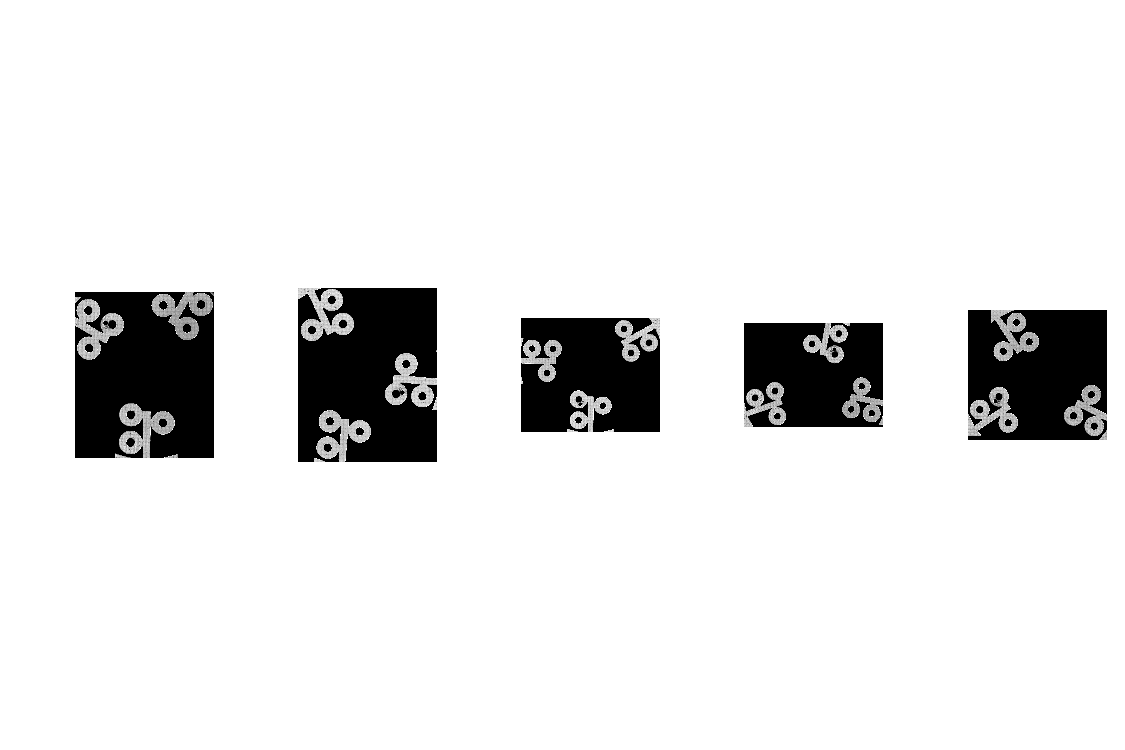

In [11]:
# Display the MPM images.
iplt.MultiImageDisplay(image_list=mpm_images)

Box(children=(IntSlider(value=119, description='image slice:', max=239), IntSlider(value=119, description='ima…

<IPython.core.display.Javascript object>


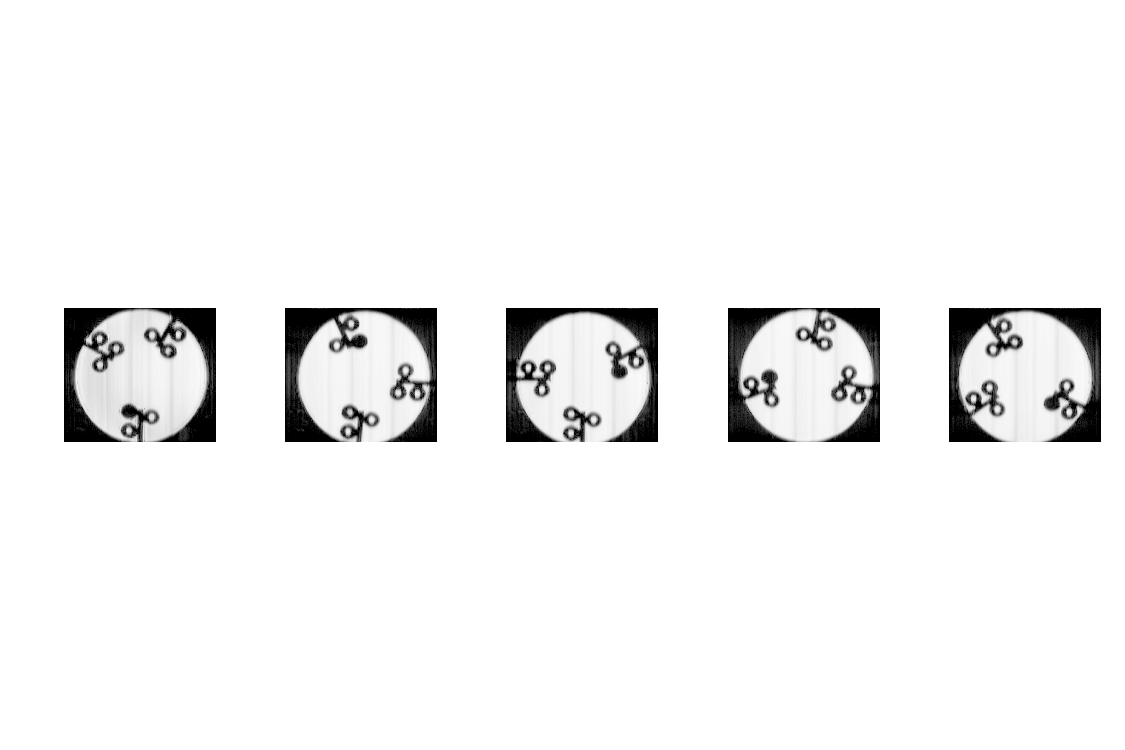

In [12]:
# Display the US images.
iplt.MultiImageDisplay(image_list=us_images)

## Point acquisition
In this section, the user manually specifies points on the multiphoton image that correspond to the US image.  This is easily done using a slice through the US shadow (slice 6).  This step may be skipped if the user wants to load pre-defined points from a file.

In [13]:
# Acquire points manually for the XY registrations.
points = []

<IPython.core.display.Javascript object>


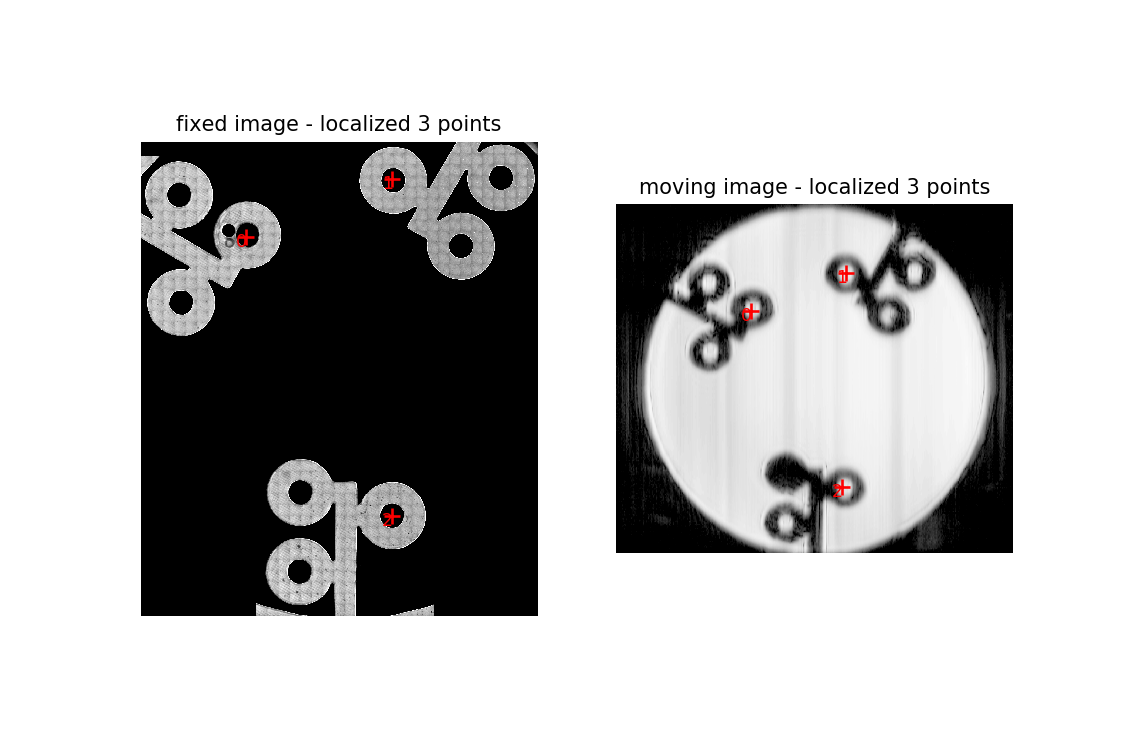

In [14]:
# This first MPM image includes extra slices to determine where the fiducial first fully appears
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[0], us_images[0]))

<IPython.core.display.Javascript object>


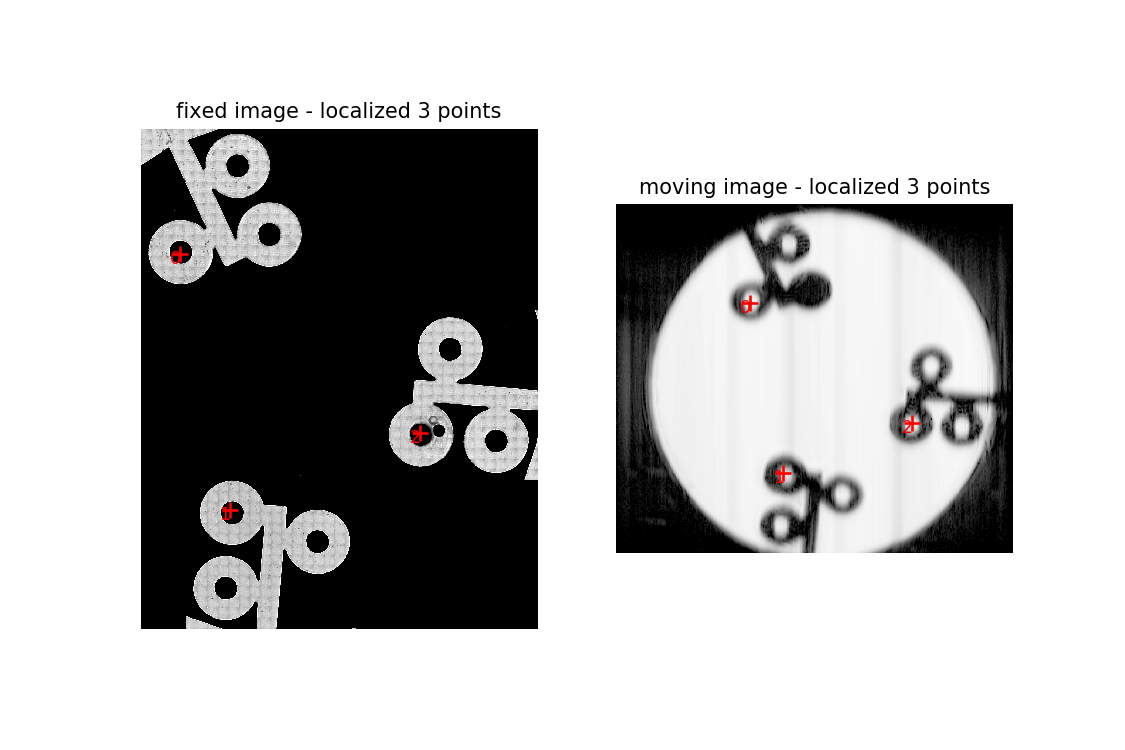

In [15]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[1], us_images[1]))

<IPython.core.display.Javascript object>


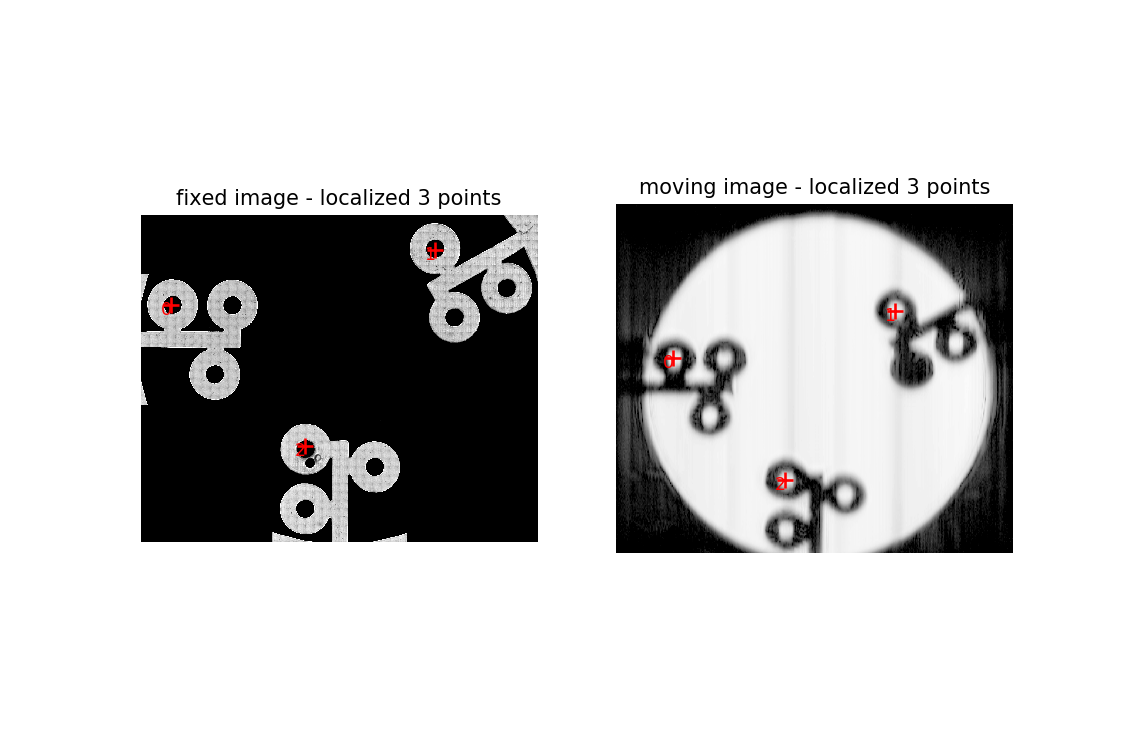

In [16]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[2], us_images[2]))

<IPython.core.display.Javascript object>


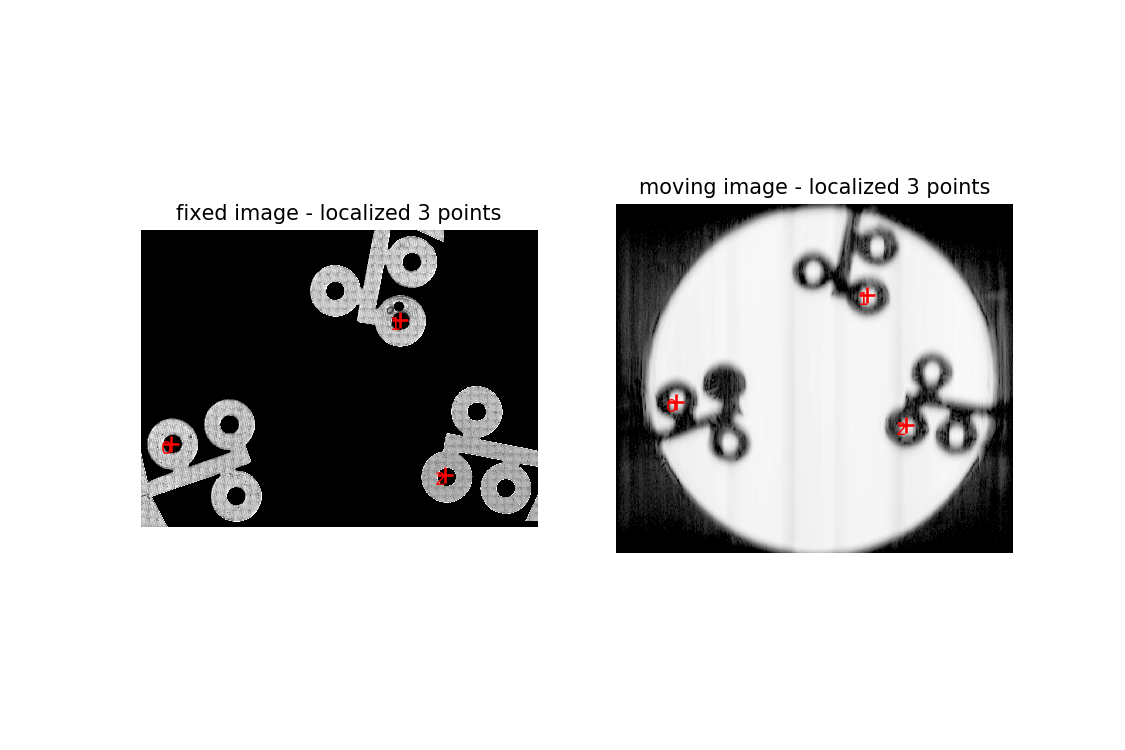

In [17]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[3], us_images[3]))

<IPython.core.display.Javascript object>


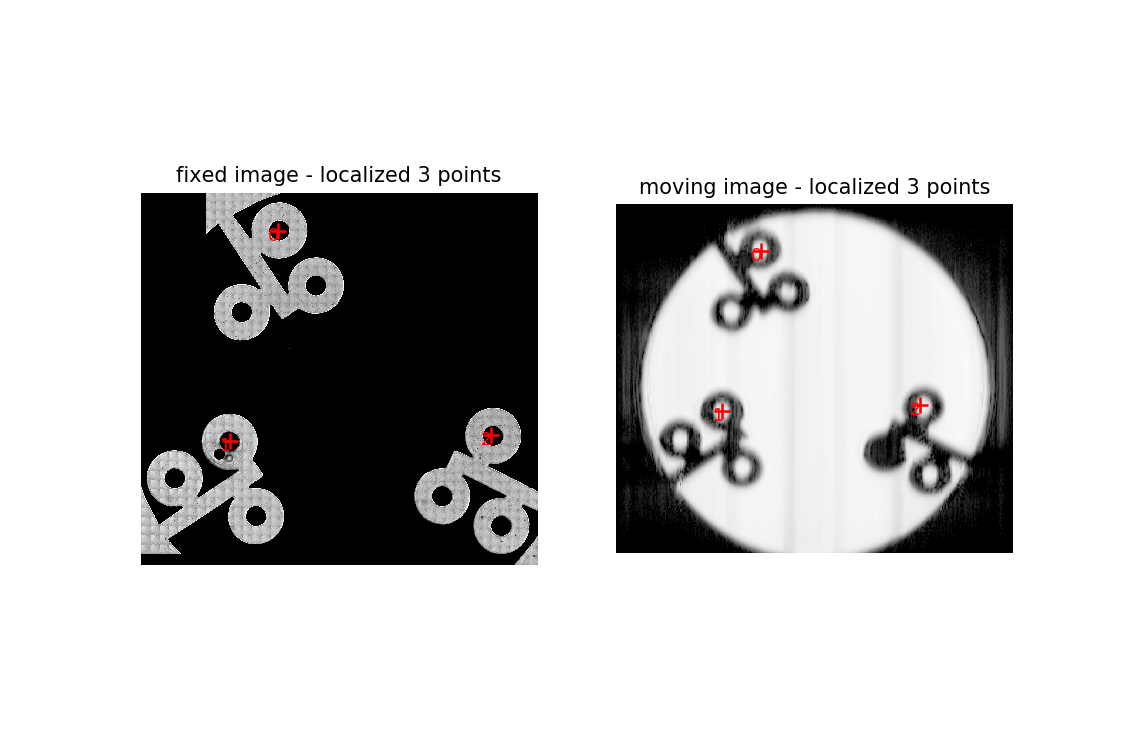

In [18]:
points.append(iplt.RegistrationPointDataAcquisition(mpm_images[4], us_images[4]))

In [19]:
fixed_points = []
moving_points = []
for idx in range(5):
    fixed, moving = points[idx].get_points_flat()
    fixed_points.append(fixed)
    moving_points.append(moving)

In [20]:
fixed_points_path = Path(fiducial_dir, 'Rotation init points - fixed.txt')
moving_points_path = Path(fiducial_dir, 'Rotation init points - moving.txt')

In [21]:
# Points previously acquired
if len(fixed_points[0]) == 0:
    with open(fixed_points_path, 'rb') as fp:
        fixed_points = pickle.load(fp)   
    with open(moving_points_path, 'rb') as fp:
        moving_points = pickle.load(fp)
else:
    with open(fixed_points_path, 'wb') as fp:
        pickle.dump(fixed_points, fp)
    with open(moving_points_path, 'wb') as fp:
        pickle.dump(moving_points, fp)

## Perform the XY registration

In [22]:
final_params = []
metrics = []
stops = []

In [23]:
for idx in range(5):
    initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points[idx], moving_points[idx])
    final_transform, metric, stop = reg.register(mpm_images[idx], us_images[idx], initial_transform=initial_transform)
    final_params.append(final_transform.GetParameters())
    metrics.append(metric)
    stops.append(stop)
    print('Finished registration {}'.format(idx+1))

Finished registration 1
Finished registration 2
Finished registration 3
Finished registration 4
Finished registration 5


The following cell may be skipped.  It either saves the results to a file or loads in results from previous attempts if the user desires to skip this step.

In [24]:
rotation_params_path = Path(fiducial_dir, 'Rotation XY parameters.txt')

if len(final_params) == 0:
    with open(rotation_params_path, 'rb') as fp:
        final_params = pickle.load(fp)
else:
    with open(rotation_params_path, 'wb') as fp:
        pickle.dump(final_params, fp)

Acquire and print the final transform and its standard deviation.  Only the X and Y results matter at this stage.  The Z coordinate is not used in the final analysis.

The first three parameters are rotations; they are ignored because they are effectively 0, with values < 0.001

In [25]:
transform_mean = np.mean(np.array(final_params), 0)
transform_std = np.std(np.array(final_params), 0)

# Print the full transform mean
print('Full transform parameters: {}'.format(transform_mean))

# Print just the X/Y transform mean and standard deviations
print('Transformation X/Y mean: {}'.format(transform_mean[3:5]))
print('Transformation X/Y standard deviation: {}'.format(transform_std[3:5]))

Full transform parameters: [ 5.87919574e-05 -2.21080487e-04 -5.01118530e-04  4.56991437e+03
  1.68602220e+03  7.00374362e+02]
Transformation X/Y mean: [4569.91436755 1686.02219599]
Transformation X/Y standard deviation: [ 4.94260405 13.96744711]


## US shadow registration
This subsection applies the transform onto the US shadow to acquire registered images for each rotation.

In [26]:
# Apply the transform onto the US image, acquiring 5 snippets of the US shadow in the MPM image volume.
registered_images = []
for idx in range(5):
    transform = sitk.VersorRigid3DTransform()
    transform.SetParameters(final_params[idx])
    registered_images.append(sitk.Resample(us_images[idx], mpm_images[idx], transform, sitk.sitkLinear, 0.0, mpm_images[idx].GetPixelID()))

Box(children=(IntSlider(value=2, description='image slice:', max=4), IntSlider(value=0, description='image sli…

<IPython.core.display.Javascript object>


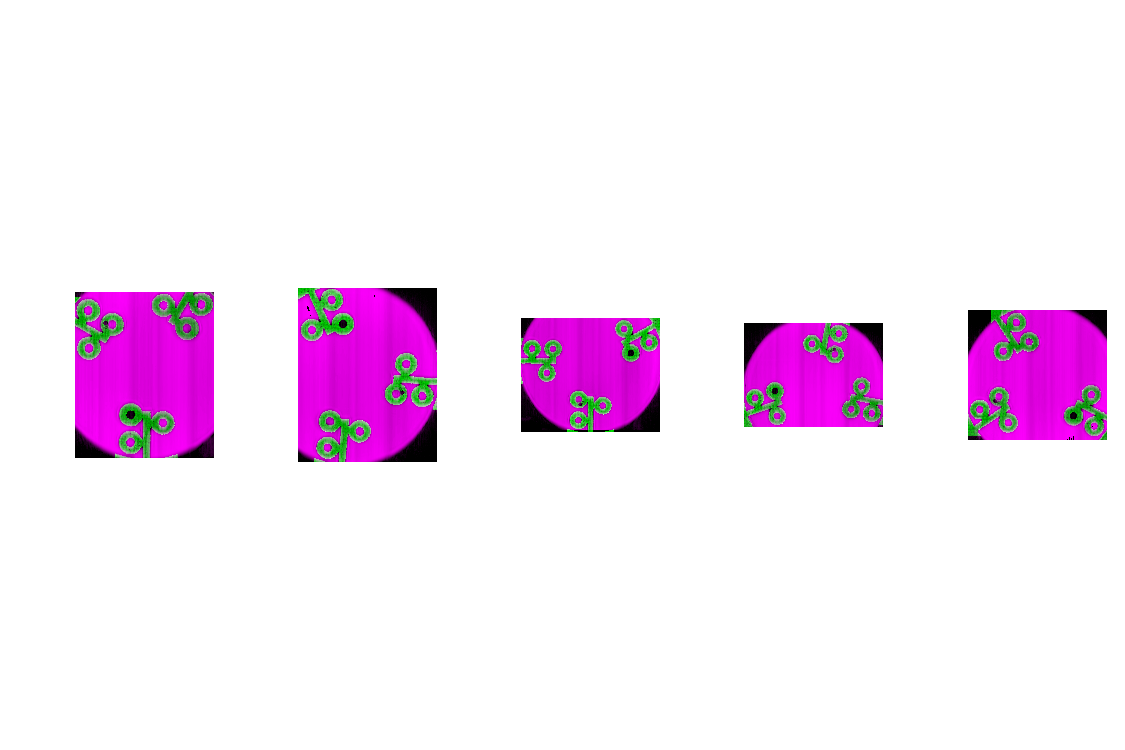

In [27]:
# Display the results.
overlay_list = [sitk.GetImageFromArray(iplt.overlay_images(registered_images[idx], mpm_images[idx])) for idx in range(5)]
iplt.MultiImageDisplay(image_list=overlay_list)

In [28]:
# Save the registered images
for idx in range(5):
    reg_path = Path(registered_dir, 'US Rot Reg {}.tif'.format(idx+1))
    sitk.WriteImage(registered_images[idx], str(reg_path))

## Z transform
This section determines the Z transform.

In [29]:
# Apply a connected component filter to the slices of the US image holding the fiducials.
rot_conn = [connected_components(image[:, :, 40:165]) for image in us_images]

Threshold used: 52.0
Threshold used: 52.0
Threshold used: 52.0
Threshold used: 54.0
Threshold used: 54.0


In [30]:
# Calculate the Z centroid for each fiducial, leveled to be at the fiducial bottom by subtracting -1, -2, or -3 mm.
rot_centroids = np.array([calculate_centroid(image) for image in rot_conn])

In [31]:
fiducial_bottom = np.mean(rot_centroids)
bottom_std = np.std(rot_centroids)
print('Fiducial coordinate bottom: {}'.format(fiducial_bottom))
print('Standard deviation: {}'.format(bottom_std))

Fiducial coordinate bottom: -896.4997245476209
Standard deviation: 67.34951021097717


In [32]:
# -4 * 25 because the fiducial first fully appears on the fifth slice of the first MPM image
z_translation = fiducial_bottom - (mpm_images[0].GetOrigin()[2] - 4*25)
print('Z translation: {}'.format(z_translation))

Z translation: 28.500275452379128


## Final transform

In [33]:
# Acquire the final coordinate transform by assigning Z translation
coordinate_transform = transform_mean.copy()
coordinate_transform[5] = z_translation

This cell saves or loads a previous final coordinate transform and may be skipped.

In [34]:
coordinate_path = Path(fiducial_dir, 'Coordinate transform.txt')
try:
    with open(coordinate_path, 'wb') as fp:
        pickle.dump(coordinate_transform, fp)
except NameError:
    with open(coordinate_path, 'rb') as fp:
        coordinate_transform = pickle.load(fp)

## US images projected downwards
This section registers a US and MPM image by projecting the images downwards or upwards by 1, 2, or 3 mm.  The purpose of this is to show how the fiducial location in MPM corresponds to the fiducial top in US.

In [35]:
# Index 0 is no shift, index 1 is 1mm, 2 is 2mm, 3 is 3mm.
height_transforms = [coordinate_transform.copy() for idx in range(4)]
for idx in range(4):
    height_transforms[idx][5] = height_transforms[idx][5] - 1000*(idx)

In [36]:
# Register the US image onto the MPM volume and save each individual image.
height_reg = [apply_transform(us_images[0], mpm_images[0], height_transforms[idx]) for idx in range(4)]
for idx in range(4):
    reg_path = Path(registered_dir, 'US Height Reg {}mm.tif'.format(idx))
    sitk.WriteImage(height_reg[idx], str(reg_path))

In [37]:
# Add together the projected US images to see all three fiducials in context.
us_all_reg = height_reg[1] + height_reg[2] + height_reg[3]
reg_path = Path(registered_dir, 'US Height All Reg.tif')
sitk.WriteImage(us_all_reg, str(reg_path))

In [38]:
# Apply the inverse transform onto the MPM image to map it to the US volume
mpm_reg = [apply_transform(mpm_images[0], us_images[0], -1*height_transforms[idx]) for idx in range(4)]
for idx in range(4):
    reg_path = Path(registered_dir, 'MPM Height Reg {}mm.tif'.format(idx))
    sitk.WriteImage(mpm_reg[idx], str(reg_path))

In [39]:
# Add together the MPM images at all 4 locations to show them in the US volume.
mpm_all_reg = mpm_reg[0] + mpm_reg[1] + mpm_reg[2] + mpm_reg[3]
reg_path = Path(registered_dir, 'MPM Height All Reg.tif')
sitk.WriteImage(mpm_all_reg, str(reg_path))